In [1]:
%pwd

'c:\\Users\\HP\\Desktop\\E-Vision-Projects\\Product_Count_API\\research'

In [2]:
import os 
%cd ..
os.getcwd()

c:\Users\HP\Desktop\E-Vision-Projects\Product_Count_API


'c:\\Users\\HP\\Desktop\\E-Vision-Projects\\Product_Count_API'

In [9]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
from PIL import Image
from glob import glob
import faiss
import random
import matplotlib.pyplot as plt

In [7]:
# Load pre-trained ResNet50 model
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        model = models.resnet50(pretrained=True)
        self.feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last layer

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Flatten output
    
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = FeatureExtractor().to(device).eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def extract_cnn_features(image):
    """Extracts feature embeddings using ResNet50."""
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = feature_extractor(image).cpu().numpy().flatten()
    
    return features  # Return feature embedding

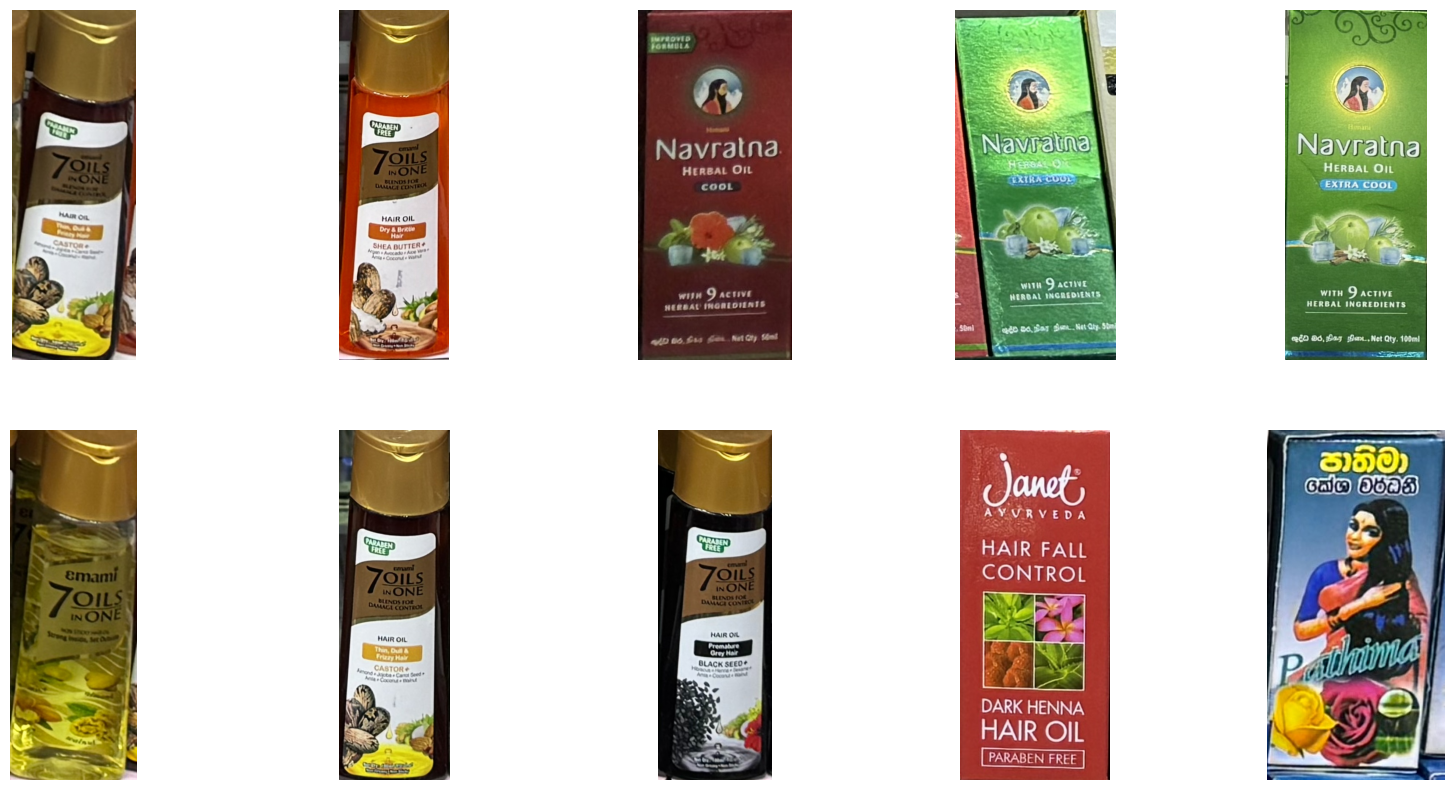

In [10]:
image_folder = './data/db'

# Get a list of all image files in the folder
image_files = glob(os.path.join(image_folder, '*/*.jpg'))

# Randomly select 10 image files
random.seed(42)
selected_images = random.sample(image_files, 10)

# Display the selected images
plt.figure(figsize=(20, 10))
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [11]:
def generate_clip_embeddings(images_path):

    image_paths = glob(os.path.join(image_folder, '*/*.jpg'))

    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = extract_cnn_features(image)
        embeddings.append(embedding)

    return embeddings, image_paths


In [12]:
IMAGES_PATH = './data/db'
embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH)

In [13]:
def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')

    return index

In [15]:
OUTPUT_INDEX_PATH = "./data/fiass_index/vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to ./data/fiass_index/vector.index


In [16]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from ./data/fiass_index/vector.index


In [17]:
def retrieve_similar_images(query,index, image_paths, top_k=3):

    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = extract_cnn_features(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)
    print(distances)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [18]:
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

In [19]:
query = './data/test_output/cropped_image_11.jpg'
query, retrieved_images = retrieve_similar_images(query, index, image_paths, top_k=1)
visualize_results(query, retrieved_images)

: 